In [1]:
# dataloader
import os
from lib.env import DATA_PATH
import json
import pandas as pd
from lib.utils import *
import matplotlib.pyplot as plt
import plotly.express as px
from torch.utils.data import DataLoader,TensorDataset,ConcatDataset
import torch
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
from sage.models import ResNetv2,ResBlockv2
from tqdm import tqdm
from sage.utils import evaluate_sigmoid
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import f1_score
DATA_PATH = f'../label-smoking-data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
TRAIN_PROJECTS = ['alsaad_phase1','alsaad_phase2','asfiqur_phase1','asfiqur_phase2','iftakhar_phase1','iftakhar_phase2']
DEV_PROJECTS = ['tonmoy_phase2']
X_train,y_train = torch.cat([torch.load(f'{DATA_PATH}/{project}.pt',weights_only=True)[0] for project in TRAIN_PROJECTS]),torch.cat([torch.load(f'{DATA_PATH}/{project}.pt',weights_only=True)[1] for project in TRAIN_PROJECTS])
X_dev,y_dev = torch.cat([torch.load(f'{DATA_PATH}/{project}.pt',weights_only=True)[0] for project in DEV_PROJECTS]),torch.cat([torch.load(f'{DATA_PATH}/{project}.pt',weights_only=True)[1] for project in DEV_PROJECTS])

In [6]:
trainloader = DataLoader(TensorDataset(X_train,y_train),batch_size=32,shuffle=True)
devloader = DataLoader(TensorDataset(X_dev,y_dev),batch_size=32,shuffle=True)

In [ ]:
hyperparameters = {
    'block':ResBlockv2,
    'widthi':[4],
    'depthi':[4],
    'n_output_neurons':1,
    'norm':'layer'
}
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

model = ResNetv2(**hyperparameters)
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [101]:
lossi = []
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

In [ ]:
val_interval = 10
model = model.to(device)

num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []
    
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.sigmoid(outputs).round().detach()
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        if (i + 1) % val_interval == 0:
            model.eval()
            val_loss = 0.0
            val_preds, val_labels_list = [], []
            with torch.no_grad():
                for val_inputs, val_labels in devloader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    
                    val_outputs = model(val_inputs)
                    val_loss += criterion(val_outputs, val_labels).item()
                    val_preds.extend(torch.sigmoid(val_outputs).round().cpu().numpy())
                    val_labels_list.extend(val_labels.cpu().numpy())

            val_loss /= len(devloader)
            val_losses.append(val_loss)

            # Compute F1 scores
            train_f1 = f1_score(train_labels, train_preds, average='macro')
            val_f1 = f1_score(val_labels_list, val_preds, average='macro')

            train_f1_scores.append(train_f1)
            val_f1_scores.append(val_f1)

            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(trainloader)}], '
                  f'Train Loss: {running_loss / val_interval:.4f}, Val Loss: {val_loss:.4f}')
            
            # Reset running loss and F1 calculation data
            train_losses.append(running_loss / val_interval)
            running_loss = 0.0
            train_preds, train_labels = [], []  # Reset for the next round
            
            model.train()  # Switch back to training mode

            # Plotting losses and F1 scores in subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            # Loss plot
            ax1.plot(train_losses, label='Train Loss')
            ax1.plot(val_losses, label='Validation Loss')
            ax1.set_xlabel('Steps (scaled by interval)')
            ax1.set_ylabel('Loss')
            ax1.set_title('Loss Curves')
            ax1.legend()

            # F1 Score plot
            ax2.plot(train_f1_scores, label='Train F1 Score')
            ax2.plot(val_f1_scores, label='Validation F1 Score')
            ax2.set_xlabel('Steps (scaled by interval)')
            ax2.set_ylabel('F1 Score')
            ax2.set_title('F1 Score Curves')
            ax2.legend()

            plt.tight_layout()
            plt.savefig('training_validation_test_curves.jpg')
            plt.close()

In [ ]:
loss,y_true,y_pred = evaluate_sigmoid(trainloader,model,criterion,device)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)
print(classification_report(y_true,y_pred))
loss,y_true,y_pred = evaluate_sigmoid(devloader,model,criterion,device)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)
print(classification_report(y_true,y_pred))

In [18]:
torch.save(model,'model.pt')

In [6]:
model = torch.load(f'model.pt',weights_only=False,map_location='cpu')
model.eval();
criterion = torch.nn.BCEWithLogitsLoss()

In [7]:
DATA_PATH = f'../data'
balance = True
project = 'tonmoy_phase2'
print(project)
fs = 100
windowsize_seconds = 25
windowsize_samples = windowsize_seconds*fs
stride_proportion = 1
stride_samples = int(windowsize_samples*stride_proportion)
labels_path = f'{DATA_PATH}/1_labeled/{project}/labels.json'
with open(labels_path, 'r') as f:
    labels = json.load(f)
regions = sorted(os.listdir(f'{DATA_PATH}/2_regions/{project}'))
print(regions)
X_test = []
y_test = []
for region in regions[:1]:
    print(region)
    X_test_i = []
    y_test_i = []
    df = pd.read_csv(f'{DATA_PATH}/2_regions/{project}/{region}')
    df.timestamp = df.timestamp.astype('datetime64[ns]')
    region_labels = [(datetime.datetime.strptime(label['start'], '%Y-%m-%d %H:%M:%S.%f'),datetime.datetime.strptime(label['end'], '%Y-%m-%d %H:%M:%S.%f')) for label in labels]
    region_labels = [label for label in region_labels if ((label[0] > df.timestamp.min()) & (label[1] < df.timestamp.max()))]
    df['y_true'] = 0
    for label in region_labels:
        df.loc[((df.timestamp > label[0]) & (df.timestamp < label[1])),'y_true'] = 1

    X = torch.from_numpy(df[['x','y','z']].values).float()
    y = torch.from_numpy(df['y_true'].values).float()

    for i in range(0,len(X) - windowsize_samples,windowsize_samples):
        X_test_i.append(X[i:i+windowsize_samples])
        y_test_i.append(y[i + (windowsize_samples // 2)])

    X_test_i = torch.stack(X_test_i).transpose(1,2)
    y_test_i = torch.tensor(y_test_i).reshape(-1,1).float()

    if torch.where(y_test_i == 1)[0].shape[0] == 0:
        continue
    
    X_test.append(X_test_i)
    y_test.append(y_test_i)
X_test = torch.vstack(X_test)
y_test = torch.vstack(y_test)
print(X_test.shape,y_test.shape)

tonmoy_phase2
['0.csv', '1.csv', '10.csv', '11.csv', '12.csv', '13.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv', '9.csv']
0.csv
torch.Size([1314, 3, 2500]) torch.Size([1314, 1])


              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      1228
         1.0       0.31      0.72      0.43        86

    accuracy                           0.88      1314
   macro avg       0.64      0.80      0.68      1314
weighted avg       0.93      0.88      0.90      1314



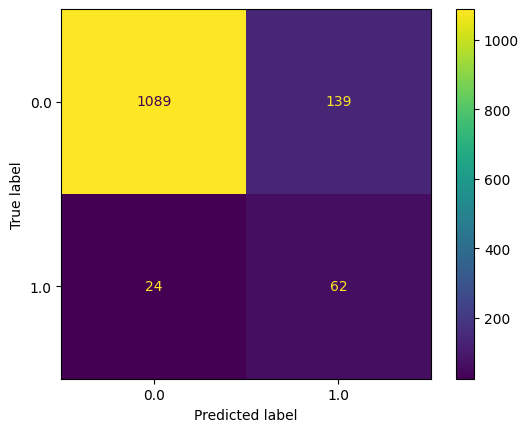

In [8]:
from sage.utils import evaluate_sigmoid

testloader = DataLoader(TensorDataset(X_test,y_test),batch_size=128,shuffle=True)
loss,y_true,y_pred = evaluate_sigmoid(testloader,model,criterion,device)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)
print(classification_report(y_true,y_pred))

In [26]:
torch.save(model,'model.pt')

In [9]:

import numpy as np
def slow_moving_average(signal, alpha=0.01):
    ema = np.zeros_like(signal)
    ema[0] = 0
    
    for t in range(1, len(signal)):
        ema[t] = alpha * signal[t] + (1 - alpha) * ema[t-1]
    
    return torch.from_numpy(ema)

In [10]:
X_plot = X_test.transpose(1,2).reshape(-1,3)

In [21]:

y_pred = model(X_test.to(device)).sigmoid().detach().cpu()
y_true = torch.from_numpy(y_test.flatten().long().numpy().repeat(2500)).unsqueeze(1)*20
y_pred_sma = torch.cat([yi.repeat(2500) for yi in slow_moving_average(y_pred,alpha=.2)])

/tmp/ipykernel_84490/1453724315.py:7: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipykernel_84490/1453724315.py:7: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.



In [22]:
fig = px.line(pd.DataFrame(torch.hstack([y_pred_sma.unsqueeze(1),y_true/20])).iloc[::100])
fig.show(renderer='browser')

In [16]:
fig = px.line(pd.DataFrame(torch.hstack([X_plot,y_pred_sma.unsqueeze(1),y_true])).iloc[::100])
fig.show(renderer='browser')

In [40]:
y_andrew = torch.zeros_like(y_pred_sma)
y_andrew[torch.where((y_pred_sma*40) > 25)[0]] = 30

In [42]:
fig = px.line(pd.DataFrame(torch.hstack([X_plot,y_pred_sma.unsqueeze(1)*40,y_true,y_andrew.unsqueeze(1)])).iloc[::1000])
fig.show(renderer='browser')

In [ ]:
torch.where(y_pred_sma > 25)

In [ ]:
plt.figure(figsize=(7.2,4.48),dpi=200)
plt.plot(X_plot,linewidth=.5)
# plt.plot(torch.cat([yi.repeat(1000) for yi in y_test.flatten().long()])*40)
# plt.plot(torch.cat([yi.repeat(1000) for yi in y_pred.flatten()])[::2]*40)
# plt.plot(y_pred_sma*40,linewidth=.5)

In [285]:
# padded_signal = F.pad(y_pred.squeeze(), (2, 2), 'constant', 0)
# window_size = 100
# filter = torch.ones(window_size) / window_size
# smoothed_signal = F.conv1d(padded_signal.unsqueeze(0), filter.unsqueeze(0).unsqueeze(0))
# smoothed_signal = smoothed_signal.squeeze()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'bottleneck_tsne' is your t-SNE output and it's an Nx2 array
num_points = bottleneck_tsne.shape[0]

# Generate a color array using the row index (e.g., from 0 to N) for a heatmap-like gradient
colors = np.linspace(0, 1, num_points)

# Plot with color mapped to the row index
plt.figure(figsize=(8, 6))
plt.scatter(bottleneck_tsne[:, 0], bottleneck_tsne[:, 1], c=colors, cmap='viridis', marker='o')
plt.title('t-SNE of Bottleneck Features with Heatmap by Row Index')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Row Index (Heatmap)')
plt.show()


In [ ]:
plt.plot(X.transpose(1,2).reshape(-1,3)[400000:420000])
plt.plot(bottleneck_tsne.repeat(1000)[400000:420000])